# La période pré-confinement Covid-19 sur les réseaux sociaux en France : collecte et analyse de données Twitter

&#127919; **Objectif du notebook** : présenter la stratégie de collecte et d'analyse de données Twitter en montrant différents outils possibles, notamment l'identification de tweets avec certaines caractéristiques, l'analyse de réseaux et de sentiments.

&#128218; **Données** : Identifiants de tweets associés au Covid-19 de différentes langues collectés par une équipe de recherche et rendus disponibles sur Zenodo <https://zenodo.org/record/3723940>

&#10067; **Question de recherche**: explorer quantitativement et qualitativement les discours autour du Covid-19 dans les premiers moments de l'épidémie

<div class="alert alert-block alert-warning">
<b>Philosophie générale</b> 
     <br>

&#10148; Notebook construit selon un modèle narratif linéaire exécutable ; <br>
    
&#10148; Priorité donnée à la lisibilité en détaillant les étapes (forte verbosité ; une cellule par étape) ; <br>

&#10148; Application des bonnes pratiques de programmation en langage Python &#128013; (structure avec [Cookiecutter Data Science](https://drivendata.github.io/cookiecutter-data-science/#directory-structure) et [Black](https://black.readthedocs.io/en/stable/index.html) pour le code) ; <br>
   
&#10148; Séparation données/traitement (entre les données brutes et le code, et dans le code) ; <br>
        
&#10148; Recherche d'un équilibre entre minimisation du nombre de bibliothèques et facilité d'usage ; <br>
            
&#10148; Documentation du code respectant les standards ([numpydoc docstrings](https://numpydoc.readthedocs.io/en/latest/format.html) utilisé notamment par [scikit-learn](https://scikit-learn.org/stable/)); <br>
    
&#10148; Mention explicite des versions de bibliothèques utilisées ; <br>

</div>

## Contexte

### Données

Nous utiliserons les tweets collectés par une équipe de recherche relatifs au Covid-19. Nous nous plaçons donc dans une **logique de réutilisation** de données ouvertes. Ces données ont certaines caractéristiques, notamment de n'être fiables qu'à partir du 11 mars 2020. Toutes les informations concernant ces données sont ici, notamment sur les conditions de collecte et les règles utilisées : https://zenodo.org/record/3723940

> The first 9 weeks of data (from January 1st, 2020 to March 11th, 2020) contain very low tweet counts as we filtered other data we were collecting for other research purposes, however, one can see the dramatic increase as the awareness for the virus spread. Dedicated data gathering started from March 11th to March 22nd which yielded over 4 million tweets a day.


Les données ne contiennent que les identifiants des tweets, en accord avec les conditions d'utilisation de Twitter. Il s'agit d'une version *déshydratée*. Une utilisation de ces données nécessite donc de procéder à une *réhydratation*.

Par ailleurs, ces données se caractérisent par un volume très important : ce sont potentiellement des dizaines de millions de tweets, qui correspondent à des gigaoctets. Pour cette raison, nous allons surtout nous concentrer sur la preuve de concept, la généralisation nécessitant de faire tourner les scripts sur une grande période.





### Démarche  générale

1. Récupérer la liste des identifiants
2. Collecter les tweets associés aux identifiants
3. Filtrer les données collectées pour se concentrer sur le cas français et constituer un corpus d'analyse
4. Explorer les données, notamment en permettant les aller/retours entre quali et quanti
5. Appliquer des traitements spécifiques : analyse de réseaux & analyse de sentiments

### Choix de bibliothèques

De nombreuses bibliothèques sont nécessaires pour réaliser ces différentes étapes

1. La collecte des tweets sera possible grâce à la bibliothèque [`twarc`](https://twarc-project.readthedocs.io/en/latest/) qui permet d'interagir avec l'API de Twitter
2. Les bibliothèques habituelles du traitement de données : `pandas`, etc. 
3. L'analyse de réseau sera permise grâce à [`networkx`](https://networkx.org/)
4. L'analyse de sentiments repose sur des transformers BERT manipulés avec Hugging Face [`transformers`](https://huggingface.co/docs/transformers/index)


## Chargement des bibliothèques

In [23]:
# installer les bibliothèques si nécessaire
%pip install -r ../requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 MB 8.0 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.4/435.4 kB 1.3 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
ERROR: Ignored the following versions that require a different python version: 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.0rc1 Requires-Python >=3.7,<3.10; 1.7.0rc2 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10
ERROR: Could not find a version that satisfies the requirement tensorflow>=2.9.1 (from versions: none)
ERROR: No matching distribution found for tensorflow>=2.9.1

[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
# Modules de base
import pickle  # stockage d'objets
import json  # format JSON
import re  # expressions régulières
import os  # interface avec le système d'exploitation (ex: fichiers)
from collections import Counter  # compteur
from pathlib import Path  # chemins de fichiers

# Collecte de données
import requests  # télécharger des fichiers et faire des requêtes API
from twarc import Twarc  # API twitter
from dotenv import dotenv_values # chargement de variables d'environnement

# Manipulation de données
import pandas as pd  # manipulation de tableaux
import numpy as np  # matrices numériques

# Visualisation
import matplotlib.pyplot as plt  # visualisation

# Traitements avancés
import spacy  # TAL
import transformers  # transformers pour l'analyse de sentiments
import networkx as nx  # analyse de réseaux

ModuleNotFoundError: No module named 'transformers'

Pour installer un module de Traitement Automatique de la Langue

In [ ]:
#%run -m spacy download fr_core_news_lg

## 1. Récupération des données

La première étape centrale est de mettre en place la stratégie de collecte des données, en récupérant d'abord les identifiants, puis en se connectant à l'API Twitter pour récupérer les données complètes.

### 1.1 Récupérer les identifiants des tweets

On télécharge en local le fichier comprenant les identifiants des tweets uniques (sans les retweets) jusqu'au 24 mars disponible sur la plateforme Zenodo. La même stratégie peut être utilisée pour télécharger les autres données qui continuent jusqu'en 2021 (disponibles sur le Github associée).

In [4]:
# Dataset sans les retweets
url = 'https://zenodo.org/record/3723940/files/full_dataset-clean.tsv?download=1'
# télécharger le fichier
data_raw = Path("../data/raw")  # dossier pour les données brutes
data_raw.mkdir(exist_ok=True)  # on crée le sous-dossier "raw" si besoin
fpath = data_raw / "full_dataset-clean.tsv"  # chemin du fichier cible (local)
r = requests.get(url)  # demander le fichier
open(fpath, 'wb').write(r.content)  # stocker le fichier en local

286149421

Chargeons le corpus comme un tableau :

In [5]:
tweets_id = pd.read_csv(fpath, sep="\t")
print(tweets_id.shape)

(7479940, 3)


Il y a 7 millions de tweets. Nous pouvons regarder l'évolution du nombre de tweets au fil du temps, avec les méthodes temporelles de Pandas qui permet d'avoir une représentation rapide en regroupant par unité de temps (ici, les jours en abscisses).

In [6]:
tweets_id["date_reco"] = pd.to_datetime(tweets_id["date"])  # mettre sous format de date
tweets_id = tweets_id.set_index("date_reco")  # mettre la date en index
tweets_id.resample("d").sum().plot(figsize=(10,5))  # regrouper par jour et afficher

<AxesSubplot:xlabel='date_reco'>

On constate bien une différence importante entre avant le 11 mars 2020 et après (changement de mode de collecte) et une cassure sur le dernier jour correspondant probablement à une collecte partielle sur la journée. Pour l'analyse, nous allons donc nous concenter sur la période du 11 au 17 mars 2020, juste avant le confinement en France.

### 1.2 Hydratation des tweets

Réalisons la sélection des tweets sur la période où la collecte est vraiment fiable, qui correspond à la période entre la reconnaissance officielle par l'OMS de l'état de pandémie mondiale et le jour du confinement annoncé en France par le président de la République le 17 mars.

In [7]:
tweets_id = tweets_id[(tweets_id.index >= "2020-03-11") & (tweets_id.index <= "2020-03-17")]
tweets_id.shape

(4014735, 3)

Il y a donc 4 millions de tweets individuels dans le jeu de données que nous souhaitons analyser.

Pour se connecter à l'API de Twitter, il est nécessaire de créer un compte d'accès et obtenir des codes de connexion. Dans notre cas, nous avons renseigné ces codes dans un fichier local `.env` sous un format de dictionnaire JSON, que nous pouvons charger avec la bibliothèque `python-dotenv` qui permet justement de faciliter la gestion de variables d'environnement comme ici.

Nous renseignons ensuite cette information à l'objet `Twarc` qui va gérer les requêtes auprès de l'API de Twitter. Il y a ensuite une méthode dédiée `hydrate` qui prend en entrée une liste d'identifiants de tweets et qui permet de récupérer le contenu complet des tweets.

**La récupération des tweets prend beaucoup de temps (jusqu'à 1 jours) et génère un volume importante de données. Pour cette raison, il est nécessaire d'envisager une stratégie qui permet de sauvegarder progressivement la récupération des données**. Pour cette raison, nous créons un nouveau fichier tous les 100 000 tweets, ce qui permettra aussi de faciliter le chargement sans saturer la mémoire. 

*Remarque : nous utilisons un format JSON pour des raisons de facilités d'ouverture, mais qui n'est pas adapté pour les gros format de fichier, d'autres formats pourraient être privilégiés comme HDF5.*

In [8]:
# chemin vers le stockage gros volume
nas_path = Path("../../notebooks-shs/dynamique des tweets covid")  # à adapter pour votre stockage
# dossier de stockage des tweets
data_tweets = nas_path / "tweets"  # sous-dossier pour les tweets

In [9]:
# chargement des clés et appel de l'API twitter
config = dotenv_values(".env")
api = Twarc(*config.values())
hydrated = api.hydrate(tweets_id["tweet_id"])

L'objet `hydrated` est un itérateur qui va permettre de faire la requête pour chaque tweet. Il suffit de faire une boucle.

In [ ]:
# Définition des variables
corpus = []
c = 0

# Pour chaque tweet
for i in hydrated:
    
    # Rechercher le tweet et le stocker
    corpus.append(i)
    
    # Tous les #100 000, créer un fichier et remettre à 0 le corpus
    if c % 100000 == 0:
        json.dump(corpus, open(data_tweets / f"corpus_tweets{c}.json", "w"))
        corpus = []
        print(c)
    c += 1
    
# écriture du corpus restant
json.dump(corpus, open(data_tweets / f"corpus_tweets{c}.json", "w"))

Au terme de ce traitement qui peut prendre de nombreuses heures, le corpus est intégralement téléchargé et stocké. Il peut donc être traité en local.

### 1.3 Filtrer uniquement les tweets en français

L'objectif est de se concentrer sur le cas français, on va donc filtrer les tweets en français. On se concentre d'abord sur les 100 000 premiers tweets dans ce cas, pour ne pas rendre l'analyse trop lourde. Une fois stabilisée, l'analyse sera généralisée sur l'ensemble des tweets. De manière générale, cette démarche est à privilégier pour traiter de grands volumes de données : débuter sur un échantillon puis généraliser une fois que le processus est stabilisé.

#### Prototypage de la mise en forme

Charger le fichier téléchargé

In [11]:
corpus = json.load(open(data_tweets / "corpus_tweets100000.json", "rb"))
len(corpus)

100000

Regarder le contenu d'un tweet, qui se présente comme une structure JSON comprenant de nombreuses informations.

In [12]:
dict(corpus[10])  # regarder le tweet à l'index 10 dans le (sous-)corpus

{'created_at': 'Wed Mar 11 00:00:46 +0000 2020',
 'id': 1237528858364006400,
 'id_str': '1237528858364006400',
 'full_text': 'Alright they’ve closed down the gym until further notice due to the coronavirus epidemic. I need at home workout suggestions and videos.',
 'truncated': False,
 'display_text_range': [0, 136],
 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []},
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 968241931871539201,
  'id_str': '968241931871539201',
  'name': 'G✨',
  'screen_name': 'g_amillia',
  'location': 'DMV 📍',
  'description': '🇻🇮•1908•PhD',
  'url': None,
  'entities': {'description': {'urls': []}},
  'protected': False,
  'followers_count': 1067,
  'friends_count': 797,
  'listed_count': 2,
  'created_at'

Toutes les informations ne nous intéressent pas nécessairement. 

On définit une fonction pour récupérer uniquement les informations qui nous intéressent pour un tweet. Suivant ce que l'on cherche à faire, il est envisageable d'ajouter d'autres informations (par exemple, sur le corpus complet, les retweets).

In [13]:
def extraire_information_tweet(t):
    """
    Extraire les informations d'un tweet
    
    Parameters
    ----------
    t : dict
        Tweet
        
    Returns
    -------
    informations : list
        Liste d'informations d'intérêt pour le tweet
    """
    informations = [t["created_at"],t["id_str"],t["full_text"],
                      t["user"]["id_str"],t["user"]["name"],t["user"]["screen_name"],t["user"]["description"],t["user"]["location"],
                      t["user"]['followers_count'],t["user"]['friends_count'],t['retweet_count'],t['favorite_count'],t['lang'],
                      t["entities"]["urls"]
                     ]
    return informations

Utilisation de la fonction pour la mise en forme d'un tableau des principales informations d'intérêt uniquement pour les tweets français. L'information donnée par Twitter sur la langue du tweet est un code "automatique". Nous pouvons vérifier que cette langue est bien identifiée, par exemple en utilisant une bibliothèque permettant la détection des langues.

In [14]:
corpus_tableau = pd.DataFrame([extraire_information_tweet(t) for t in corpus if t['lang'] == "fr"], 
                                columns = ["date","id","texte","user_id","user_name","user_screename",
                                "user_description","user_location","user_followers","user_friends","retweet",
                                "fav","langue","urls"])
corpus_tableau.head()

date                   id  \
0  Wed Mar 11 00:05:12 +0000 2020  1237529974053040130   
1  Wed Mar 11 00:13:11 +0000 2020  1237531983086940162   
2  Wed Mar 11 00:24:44 +0000 2020  1237534889764728834   
3  Wed Mar 11 00:37:16 +0000 2020  1237538043881390080   
4  Wed Mar 11 00:55:20 +0000 2020  1237542590506885122   

                                               texte              user_id  \
0  Avec toute cette histoire du #coronavirus, un ...           3334948276   
1  @letellier_ftv @florencemehrez Si en plus le c...           1350389808   
2  @nfsdv @cavanista__ t’a 68 ans fait gaffe au C...   918848259237478400   
3  Moi j'hallucine comment les gens s'en foutent ...  1088863364883902467   
4  @Adelqlf_ @ozyrnandias Les billets sont à 400€...  1116706059580784640   

     user_name user_screename  \
0     UwUtsugi  REDemption_Kh   
1  Laurent mat       loupdmer   
2         Koko       madkng24   
3  Xavier Lund     LundXavier   
4            🧧     loclacgang   

                                    user_description    user_location  \
0                                                              France   
1  humaniste patient et pondéré, ami du riche et ...          St Malo   
2              Just Be Better | سُبْحَانَ ٱللَّٰهِ |         Valyria    
3                                                                       
4   ont est pas des bandits, ont a juste mal grandit  Malaga, Espagne   

   user_followers  user_friends  retweet  fav langue urls  
0            1569           823        0    2     fr   []  
1            1637          3897        0    1     fr   []  
2             729            90        0    0     fr   []  
3               0             2        0    0     fr   []  
4              29            82        1    0     fr   []

Cela correspond bien au format qui nous intéresse. 

#### Généralisation sur l'ensemble des fichiers téléchargés pour extraire le corpus français

Pour le besoin de ce traitement, les données ont déjà été téléchargées et sont stockées en interne dans le dossier `tweets` sur le NAS. En raison de la non-diffusion des données complètes, nous ne pouvons pas rendre ces données accessibles, mais voici le code utilisé pour produire le tableau utilisé ensuite.

Comme le volume de données est important et que les fichiers JSON prennent beaucoup de mémoire vive pour être lus, il est nécessaire de réfléchir à l'occasion mémoire. Nous faisons le choix de charger les fichiers en créant des DataFrames au fur et à mesure puis les concaténer, ce qui est une solution souple et efficace quand on traite de gros volumes de données. Pour éviter les pics d'occupation mémoire et faciliter la reproductibilité, nous prenons soin de supprimer les fichiers intermédiaires (ce que fait généralement de manière invisible le ramasse-miettes de Python).

In [33]:
# Boucle sur les fichiers
for i in os.listdir(data_tweets):
    
    # charger les données d'un fichier (long car chaque JSON est volumineux)
    data = json.load(open(data_tweets / i, "rb"))

    # ne conserver que les tweets en français
    corpus_fr = [extraire_information_tweet(t) for t in data if t['lang'] == "fr"]
    
    # si aucun tweet en français, on passe au fichier suivant
    if not corpus_fr:
        continue

    # créer un DataFrame avec ces tweets
    df_corpus_fr = pd.DataFrame(corpus_fr, 
                                columns=["date", "id", "texte", "user_id", "user_name", "user_screename",
                                "user_description", "user_location", "user_followers", "user_friends", "retweet",
                                "fav", "langue", "urls"])

    # ajouter ce DataFrame aux précédents
    liste_corpus_total_fr.append(df_corpus_fr)
    
    # supprimer explicitement les variables non-utilisées
    del data
    del corpus_fr
    
# Mise en forme finale
corpus_total_fr = pd.concat(liste_corpus_total_fr, ignore_index=True)
corpus_total_fr.shape

(182253, 14)

Nous modifions encore notre corpus pour enlever les doublons éventuels.

In [34]:
corpus_total_fr = corpus_total_fr.loc[corpus_total_fr["id"].drop_duplicates().index]
corpus_total_fr.shape

(134735, 14)

Nous avons obtenu le tableau d'intérêt. Nous le stockons dans un objet `pickle` pour reprendre l'analyse si besoin plus tard sans avoir besoin de refaire toutes ces étapes. **C'est ce tableau que nous allons ensuite utiliser pour les analyses**.

In [35]:
pickle.dump(corpus_total_fr, open("../data/interim/corpus_total_fr.pickle", "wb"))

## 2. Exploration du corpus

Nous allons explorer le corpus de tweets français constitué sur les jours juste avant le confinement en France, donc à un moment où les discussions étaient déjà largement présentes dans l'espace public. Pour cela, il convient de charger le jeu de données constitué pour l'analyse.

In [15]:
# Chargement du fichier si besoin pour reprendre l'analyse ultérieurement
corpus_total_fr = pickle.load(open("../data/interim/corpus_total_fr.pickle", "rb"))
# Assurer que le format date est au bon format
corpus_total_fr["date"] = pd.to_datetime(corpus_total_fr["date"])
# Mettre la date en index
corpus_total_fr = corpus_total_fr.set_index("date")
corpus_total_fr.head()

id  \
date                                             
2020-03-11 00:05:12+00:00  1237529974053040130   
2020-03-11 00:13:11+00:00  1237531983086940162   
2020-03-11 00:24:44+00:00  1237534889764728834   
2020-03-11 00:37:16+00:00  1237538043881390080   
2020-03-11 00:55:20+00:00  1237542590506885122   

                                                                       texte  \
date                                                                           
2020-03-11 00:05:12+00:00  Avec toute cette histoire du #coronavirus, un ...   
2020-03-11 00:13:11+00:00  @letellier_ftv @florencemehrez Si en plus le c...   
2020-03-11 00:24:44+00:00  @nfsdv @cavanista__ t’a 68 ans fait gaffe au C...   
2020-03-11 00:37:16+00:00  Moi j'hallucine comment les gens s'en foutent ...   
2020-03-11 00:55:20+00:00  @Adelqlf_ @ozyrnandias Les billets sont à 400€...   

                                       user_id    user_name user_screename  \
date                                                                         
2020-03-11 00:05:12+00:00           3334948276     UwUtsugi  REDemption_Kh   
2020-03-11 00:13:11+00:00           1350389808  Laurent mat       loupdmer   
2020-03-11 00:24:44+00:00   918848259237478400         Koko       madkng24   
2020-03-11 00:37:16+00:00  1088863364883902467  Xavier Lund     LundXavier   
2020-03-11 00:55:20+00:00  1116706059580784640            🧧     loclacgang   

                                                            user_description  \
date                                                                           
2020-03-11 00:05:12+00:00                                                      
2020-03-11 00:13:11+00:00  humaniste patient et pondéré, ami du riche et ...   
2020-03-11 00:24:44+00:00              Just Be Better | سُبْحَانَ ٱللَّٰهِ |   
2020-03-11 00:37:16+00:00                                                      
2020-03-11 00:55:20+00:00   ont est pas des bandits, ont a juste mal grandit   

                             user_location  user_followers  user_friends  \
date                                                                       
2020-03-11 00:05:12+00:00           France            1569           823   
2020-03-11 00:13:11+00:00          St Malo            1637          3897   
2020-03-11 00:24:44+00:00         Valyria              729            90   
2020-03-11 00:37:16+00:00                                0             2   
2020-03-11 00:55:20+00:00  Malaga, Espagne              29            82   

                           retweet  fav langue urls  
date                                                 
2020-03-11 00:05:12+00:00        0    2     fr   []  
2020-03-11 00:13:11+00:00        0    1     fr   []  
2020-03-11 00:24:44+00:00        0    0     fr   []  
2020-03-11 00:37:16+00:00        0    0     fr   []  
2020-03-11 00:55:20+00:00        1    0     fr   []

### 2.1 Evolution générale

Une première étape est d'avoir une idée de l'évolution du nombre de tweets dans le corpus en fonction du temps, dans notre cas on peut l'avoir par heure.

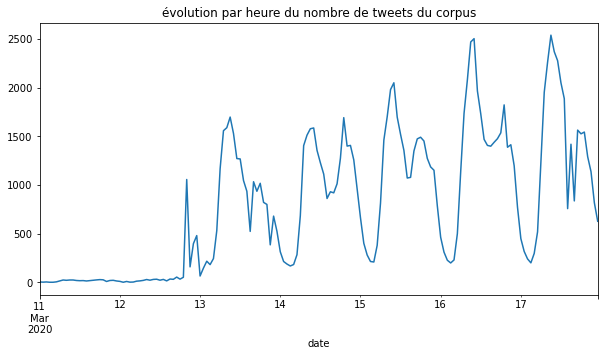

In [16]:
corpus_total_fr.resample("h")["id"].count().plot(figsize=(10,5))
plt.title("évolution par heure du nombre de tweets du corpus")
plt.show()

Les pics et les creux d'activité (périodes de sommeil) sont nettement visibles. La collecte semble avoir vraiment débuté à partir du 13 mars. Pour avoir un corpus propre, nous allons nous concentrer sur la période à partir du 13 en filtrant notre corpus.

In [17]:
corpus_total_fr = corpus_total_fr[corpus_total_fr.index >= "13-03-2020"]
corpus_total_fr.shape

(131765, 13)

### 2.2 Identifier les tweets les plus visibles

Avoir une base de données bien construite signifie qu'il est possible de circuler dans le contenu pour explorer qualitativement l'information. Identifions les comptes les plus présents dans le corpus (les plus actifs sur cette question) et les tweets qui ont eu le plus de visibilité.

Qui sont les utilisateurs les plus actifs sur cette thématique ?

In [18]:
corpus_total_fr.groupby("user_screename")['user_screename'].count().sort_values(ascending=False)[0:10]

user_screename
CuriousKd2000      334
dakarxibar         174
le_Parisien        166
titrespresse       162
1001portails_fr    147
DiploMix           147
BFMTV              142
Afropages          141
herodote1789        96
Drumpemag           86
Name: user_screename, dtype: int64

Les comptes les plus actifs sont des particuliers, qui ont surtout diffusé des articles de presse.

Et les tweets qui ont eu le plus d'interaction (like ou retweet) ? Pour le savoir, on construit un indicateur qui additionne les retweets et les "j'aime" (fav), puis on trie par cet indicateur.

In [19]:
corpus_total_fr["total_interaction"] = corpus_total_fr["retweet"] + corpus_total_fr["fav"]
corpus_total_fr.sort_values("total_interaction", ascending=False)[["user_screename","id","texte","total_interaction"]].head()

user_screename                   id  \
date                                                            
2020-03-16 07:40:12+00:00   JS_alaprod57  1239456418647900160   
2020-03-17 08:42:47+00:00   patrick_baud  1239834555235868672   
2020-03-16 09:53:46+00:00       ayeritaa  1239490031779266560   
2020-03-13 10:40:32+00:00     Furotrixer  1238414636350877696   
2020-03-16 11:31:34+00:00     MaelleRiou  1239514643137204224   

                                                                       texte  \
date                                                                           
2020-03-16 07:40:12+00:00  Pour éviter le Covid-19 a partir de ce soir je...   
2020-03-17 08:42:47+00:00  En cas de non respect de confinement, vous pai...   
2020-03-16 09:53:46+00:00  Il abuse à toujours parler au moment des marse...   
2020-03-13 10:40:32+00:00  Le coronavirus quand il va vouloir venir nous ...   
2020-03-16 11:31:34+00:00  enfaite c’est juste tous les 100ans la planète...   

                           total_interaction  
date                                          
2020-03-16 07:40:12+00:00             180380  
2020-03-17 08:42:47+00:00              66766  
2020-03-16 09:53:46+00:00              64384  
2020-03-13 10:40:32+00:00              55480  
2020-03-16 11:31:34+00:00              49047

[[[[[[[[[[[[[[[[[[[[ ERREUR ICI A REPRENDRE AVEC LE STATUT QUI N'EST PAS OK

Pour voir le tweet, on peut soit passer par l'interface Twitter sur <https://twitter.com/JS_alaprod57> (ex: <https://twitter.com/JS_alaprod57/status/1239456418647900160> ), soit définir une classe qui permet d'afficher directement dans le Notebook un tweet à partir de son identifiant, ce qui nous sera utile pour plus tard. Une classe est une manière de définir un nouvel objet.

In [20]:
class Tweet(object):
    def __init__(self, s):
        s = f"https://twitter.com/OReillyMedia/status/{s}"
        api = 'https://publish.twitter.com/oembed?url={}'.format(s)
        response = requests.get(api)
        self.text = response.json()["html"]

    def _repr_html_(self):
        return self.text

Utilisons la classe pour un tweet  : 

In [21]:
Tweet("1239456418647900160")

La dimension politique de la gestion de la crise est très présente... mais l'humour aussi.

### 2.3 Extraire de l'information d'un tweet : les #hashtags

Parmi les dimensions souvent analysées dans les interactions sur Twitter, les hashtags sont souvent le premier choix car ils sont faciles à extraire et sont porteurs de positionnement. Les #hashtags peuvent se retrouver à la fois dans les tweets et dans les notices biographies. On veut donc regarder la distribution des # dans les tweets et les biographies.

La première étape est d'extraire les hashtags. La solution la plus souple est d'utiliser les expressions régulières pour identifier tous les mots qui commencent par un dièse (`#`).

In [22]:
expression = "#(\w+)"
re.findall(expression, "Phrase de test avec #un #hashtag#malséparé")

['un', 'hashtag', 'malséparé']

On construit donc une fonction qui renvoie la liste que nous souhaitons. Nous faisons aussi le choix de les mettre en minuscules.

In [23]:
def extraire_hashtags(texte):
    """
    Extraire les hashtags d'un texte
    """
    expression = "#(\w+)"
    liste = re.findall(expression, texte.lower())
    return liste

Nous pouvons donc maintenant appliquer la fonction sur l'ensemble de nos tweets.

In [24]:
corpus_total_fr["hashtags"] = corpus_total_fr["texte"].apply(extraire_hashtags)

Et regarder la distribution des hashtags sur l'ensemble de notre corpus en créant un objet compteur.

In [25]:
# créer un compteur
from collections import Counter
compteur = Counter()

# Ajouter chaque liste
for l in list(corpus_total_fr["hashtags"]):
    compteur.update(l)
    
# Regarder les plus fréquents
compteur.most_common(20)

[('coronavirus', 25635),
 ('covid19', 13984),
 ('covidー19', 3839),
 ('covid_19', 2814),
 ('confinement', 2106),
 ('coronavirusfrance', 1872),
 ('covid19france', 1595),
 ('confinementtotal', 1526),
 ('restezchezvous', 1166),
 ('macron', 1081),
 ('coronavirusenfrance', 1011),
 ('municipales2020', 945),
 ('france', 867),
 ('covid2019', 692),
 ('restecheztoi', 649),
 ('resterchezvous', 437),
 ('covid19fr', 420),
 ('covid', 390),
 ('coronavirusfr', 384),
 ('municipale2020', 371)]

Sans surprise, les hashtags les plus fréquents sont largements associés au COVID. Néanmoins, la présence du confinement arrive en cinquième position.

La question se pose souvent de l'évolution des hashtags. Il est donc possible de regrouper nos données par jour et regarder le classement des hashtags utilisés pour regarder l'arrivée de certains termes.

In [26]:
tableau = {}

for i, tab in corpus_total_fr.resample("d"):
    compteur = Counter()
    for l in list(tab["hashtags"]):
        compteur.update(l)
    tableau[i.day] = compteur.most_common(10)
pd.DataFrame(tableau)

13                        14  \
0         (coronavirus, 4270)       (coronavirus, 4755)   
1             (covid19, 1434)           (covid19, 1711)   
2            (covid_19, 1388)          (covidー19, 1186)   
3          (confinement, 176)           (covid_19, 553)   
4               (macron, 175)  (coronavirusfrance, 269)   
5        (coronavirusfr, 166)        (confinement, 259)   
6  (coronaviruspandemic, 133)       (restecheztoi, 248)   
7      (municipales2020, 118)    (coronapocalypse, 208)   
8               (france, 117)    (municipales2020, 183)   
9            (macron20h, 103)             (macron, 149)   

                           15                          16  \
0         (coronavirus, 4663)         (coronavirus, 6529)   
1             (covid19, 2434)             (covid19, 4248)   
2            (covidー19, 1591)    (confinementtotal, 1024)   
3    (coronavirusfrance, 787)             (covidー19, 845)   
4      (municipales2020, 433)          (confinement, 736)   
5       (restezchezvous, 331)        (covid19france, 591)   
6  (coronavirusenfrance, 325)  (coronavirusenfrance, 571)   
7       (municipale2020, 263)               (macron, 385)   
8         (restecheztoi, 258)    (coronavirusfrance, 376)   
9             (covid_19, 253)             (covid_19, 312)   

                         17  
0       (coronavirus, 5418)  
1           (covid19, 4157)  
2      (covid19france, 851)  
3        (confinement, 687)  
4          (covid2019, 507)  
5   (confinementtotal, 492)  
6     (restezchezvous, 392)  
7  (coronavirusfrance, 355)  
8    (confinementotal, 336)  
9           (covid_19, 308)

Le mot clé du confinement arrive dans les hashtags les plus partagés vers le 13/03.

La même stratégie peut être appliquée cette fois non sur les tweets mais sur les biographies, qui sont les descriptifs des comptes qui tweetent. En effet, les hashtags sont utilisés pour marquer certaines appartenances.

In [27]:
compteur = Counter()

# Ajouter chaque liste
for l in list(corpus_total_fr["user_description"].drop_duplicates().apply(extraire_hashtags)):
    compteur.update(l)
    
# Regarder les plus fréquents
compteur.most_common(20)

[('teamom', 345),
 ('digital', 327),
 ('innovation', 315),
 ('communication', 218),
 ('santé', 184),
 ('politique', 182),
 ('socialmedia', 169),
 ('culture', 159),
 ('marketing', 155),
 ('psg', 152),
 ('formation', 148),
 ('blacklivesmatter', 147),
 ('rse', 135),
 ('numérique', 129),
 ('paris', 128),
 ('environnement', 125),
 ('sport', 124),
 ('rh', 114),
 ('france', 109),
 ('emploi', 108)]

Clairement, la thématique du Covid-19 n'a pas encore pris place dans les biographies. Cela viendra plus tard, notamment avec les polarisations autour des masques et des vaccins.

### 2.4 La circulation des URL

Une autre dimension importante est la circulation des liens vers d'autres médias. Nous avons gardé la structure d'ensemble du JSON, mais dans les faits nous ne voulons que la version "expanded", en ne gardant que les liens qui ne pointent pas vers Twitter même. Et comme précédemment, nous appliquons un compteur.

In [28]:
# On ne garde que les liens
liens = corpus_total_fr["urls"].apply(lambda x : [i['expanded_url'] for i in x if not "twitter" in i['expanded_url']])

# On crée un compteur
compteur = Counter()
for l in list(liens):
    compteur.update(l)

# On regarde les plus fréquents    
compteur.most_common(10)

[('https://medium.com/@tomaspueyo/coronavirus-agissez-aujourdhui-2bd1dc7838f6',
  223),
 ('https://www.gouvernement.fr/info-coronavirus', 215),
 ('https://www.lemonde.fr/politique/article/2020/03/17/entre-campagne-municipale-et-crise-du-coronavirus-le-chemin-de-croix-d-agnes-buzyn_6033395_823448.html',
  163),
 ('https://www.lemonde.fr/planete/article/2020/03/15/coronavirus-les-simulations-alarmantes-des-epidemiologistes-pour-la-france_6033149_3244.html',
  130),
 ('https://www.francebleu.fr/infos/sante-sciences/coronavirus-le-traitement-a-la-chloroquine-a-marseille-serait-efficace-1584392554',
  80),
 ('https://next.liberation.fr/livres/2020/03/12/coronavirus-chers-cousins-francais-par-cristina-comencini_1781454',
  51),
 ('https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca',
  51),
 ('https://www.lemonde.fr/politique/article/2020/03/16/coronavirus-l-executif-reflechit-a-confiner-les-francais_6033188_823448.html',
  50),
 ('https://www.lemonde.fr/les-

Le lien le plus tweeté est le long article d'alerte de Tomas Pueyo.

### 2.5 Analyse qualitative du corpus

Le tableau des données permet de facilement circuler de manière qualitative dans le corpus. Cela signifie qu'il permet de procéder à des réflexions exploratoires. Par exemple, nous aimerions regarder comment les médecins sont intervenus sur cette période. Nous voulons donc extraire un sous-corpus de tweets.

Plusieurs stratégies sont possibles : soit nous disposons d'une liste d'identifiants de médecins, et nous identifions leurs tweets dans le corpus ; soit nous partons du principe qu'ils ont indiqué leur statut de médecins dans la biographie Twitter (souvent des comptes officiels). Par contre, cela nécessite ensuite un travail de nettoyage manuel

In [29]:
(corpus_total_fr["user_description"].str.lower()).str.contains("médecin").sum()

789

Il y a environ 233 comptes qui mentionnent "médecin". Le terme de médecin pourrait être limité, et ce serait bien d'étendre les termes recherchés.
Une stratégie est de constituer un dictionnaire de termes. Pour le faire de manière semi-automatique, il est intéressant d'utiliser les modèles de traitement de la langue qui incorporent une "distance" entre les mots, et de regarder les mots associés au mot "médecin" :

In [30]:
# Chargement d'un modèle
nlp = spacy.load('fr_core_news_lg')

mot = "médecin"

# on demande au modèle de renvoyer les 20 mots qui sont, dans son espace vectoriel,
# les plus similaires au mot "médecin"
ms = nlp.vocab.vectors.most_similar(np.asarray([nlp(mot).vector]), n=20)
# on extrait les mots et on les met en minuscules
[nlp.vocab.strings[w].lower() for w in ms[0][0]]

['médecin',
 'ex-médecin',
 'mèdecin',
 'urologue',
 'pharmacien',
 'ophtalmologue',
 'chirurgien',
 'cardiologue',
 'vétérinaire',
 'gynécologue',
 'proctologue',
 'rhumatologue',
 'ophtalmologiste',
 'psychiatre',
 'pédiatre',
 'dermatologue',
 'decin',
 'obstétricien',
 'medecin',
 'praticien']

Constituons donc une liste, que l'on peut compléter par ailleurs

In [31]:
liste = ['médecin',
 'mèdecin',
 'urologue',
 'pharmacien',
 'ophtalmologue',
 'chirurgien',
 'cardiologue',
 'vétérinaire',
 'gynécologue',
 'proctologue',
 'rhumatologue',
 'ophtalmologiste',
 'psychiatre',
 'pédiatre',
 'dermatologue',
 'obstétricien',
 'medecin']

In [32]:
# on cherche toutes les descriptions contenant au moins un des termes de la liste
f = (corpus_total_fr["user_description"].str.lower()).str.contains("|".join(liste))
f.sum()

1090

On a un peu plus de comptes

In [33]:
corpus_total_fr[f].groupby("user_screename")["user_name"].count().sort_values(ascending=False).head()

user_screename
Fraslin            37
T_Nenninger        19
philippedocteur    18
Eric_vds           14
madocdoc           14
Name: user_name, dtype: int64

Le médecin qui s'est le plus exprimé est `Fraslin`, regardons ses tweets

In [34]:
corpus_total_fr[corpus_total_fr["user_screename"] == "Fraslin"]["texte"]

date
2020-03-13 06:43:24+00:00    Comment on fait pour avoir une classe politiqu...
2020-03-13 08:18:14+00:00    Jeune femme enceinte originaire de Taiwan. Son...
2020-03-13 09:28:52+00:00    #Coronavirus "Comment Gérard Larcher a mis la ...
2020-03-14 06:11:24+00:00    @Vfk2A @DocArnica @ars_pdl On a un cas local (...
2020-03-14 06:17:05+00:00    Espérons que la production va s'améliorer.\nht...
2020-03-14 07:25:24+00:00    Poke @qffwffq, @Disciple_Neuro \nJe suis perpl...
2020-03-13 16:30:28+00:00    @GaetanTech @TroncheBiais @qffwffq @ContactPri...
2020-03-14 12:10:24+00:00    @LehmannDrC Il est fils du pasteur évangélique...
2020-03-14 12:17:58+00:00    @module5 @ameli_actu @CISManche Que le Dossier...
2020-03-14 17:25:53+00:00    #Coronovirus Italie. La létalité (nombre de dé...
2020-03-14 18:20:21+00:00    @PresqueRire Analyse des décès #Coronavirus It...
2020-03-14 18:52:24+00:00    «Nous pensons que le coronavirus va probableme...
2020-03-14 19:27:33+00:00    En Italie, le conf

Une lecture attentive des tweets et de leurs évolutions permet de caractériser un compte. Cependant, il est intéressant d'aller plus loin et de caractériser les interventions de manière plus globale. Les outils de traitements automatiques de la langue (TAL) permettent de tels traitements, notamment avec certaines méthodes de machine learning comme pour la détection des sentiments.

## 3. Application de détection des sentiments sur les tweets

Une des avancées importantes amenées par le développement du *deep learning* est l'amélioration des stratégies d'analyse de sentiments des textes. Dans le cas de Twitter, qui est un réseau social dans lequel prennent place de nombreuses polémiques, la détection de sentiments est intéressante pour pointer les controverses. 

### 3.1 Choix des modèles

Il existe beaucoup de stratégies pour faire de l'analyse de sentiment, certaines utilisant des dictionnaires de mots, d'autres des modèles de deep learning. Le point crucial est que les modèles sont entrainés sur des corpus différents. Tous les modèles produisent des erreurs. Il faut donc sélectionner le modèle le plus pertinent à la tâche.

De nombreux modèles de type BERT sont disponibles sur HuggingFace. La bibliothèque `transformers` va directement chercher sur la base de données HuggingFace les modèles. Il existe une catégorie de ces modèles qui correspond à l'analyse de sentiment en français : https://huggingface.co/models?language=fr&pipeline_tag=text-classification&sort=downloads&search=sentiment

Nous pouvons donc en installer plusieurs pour les tester.

- Un premier modèle est générique et entrainé sur des données de critiques de films. Pour cette raison, le résultat se fait sous la forme d'un label de 1 à 5 étoiles, et une probabilité associée : https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment
- Un deuxième modèle a été entraîné spécifiquement sur des tweets COVID : https://huggingface.co/Monsia/camembert-fr-covid-tweet-sentiment-classification



In [35]:
from transformers import pipeline

# importer les deux modèles
modele1 = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")
modele2 = pipeline("sentiment-analysis", model="Monsia/camembert-fr-covid-tweet-sentiment-classification")

Il est possible maintenant d'utiliser les modèles pour classifier des textes. Faisons un petit texte.

In [36]:
texte1 = "Je suis vraiment énervé par cette épidémie"
texte2 = "Nous avons de la chance d'avoir un bon système de santé"

print("Texte:",texte1)
print(modele1(texte1))
print(modele2(texte1))
print("Texte:",texte2)
print(modele1(texte2))
print(modele2(texte2))

Texte: Je suis vraiment énervé par cette épidémie
[{'label': '1 star', 'score': 0.49285465478897095}]
[{'label': 'negatif', 'score': 0.9633922576904297}]
Texte: Nous avons de la chance d'avoir un bon système de santé
[{'label': '4 stars', 'score': 0.36131685972213745}]
[{'label': 'positif', 'score': 0.9229389429092407}]


Sur ces phrases explicites, la classification semble fonctionner. La phrase très négative obtient le label une étoile (au sens de l'échelle de la critique du cinéma, corpus sur lequel le modèle a été entraîné) avec cependant un score assez ambigu de fiabilité (0.49 sur 1) et le label négatif avec l'autre modèle spécifique aux tweets avec un score très fort de fiabilité (0.96 sur 1). La situation est similaire pour le tweet positif, cette fois-ci avec un label 4 étoiles et positif. 

Est-ce que ces modèles fonctionnent aussi sur le corpus réel ? Pour cela, nous prenons un échantillon pour tester:

In [37]:
textes = list(corpus_total_fr.sample(10,random_state=42)["texte"])
for t in textes:
    print("Texte:",t,"\n",modele1(t),"\n",modele2(t),"\n\n")

Texte: « De la crise du coronavirus, on peut tirer des leçons pour lutter contre le changement climatique » #france #sante 
 [{'label': '4 stars', 'score': 0.32876747846603394}] 
 [{'label': 'neutre', 'score': 0.7088533043861389}] 


Texte: Lutte contre le #coronavirus : les #Evêques du #Togo prennent des dispositions - https://t.co/hOwBowF8o9 #Eglise #Vatican #Catholique #Santé 
 [{'label': '4 stars', 'score': 0.25365808606147766}] 
 [{'label': 'positif', 'score': 0.8534911870956421}] 


Texte: Bande d'ingrats. Pizza hawaïenne c'est l'une des meilleures. https://t.co/58rsrODF5a 
 [{'label': '5 stars', 'score': 0.6695896983146667}] 
 [{'label': 'negatif', 'score': 0.956425130367279}] 


Texte: Maggie De Block défend sa gestion de la crise du coronavirus: "Je ne vois pas pourquoi on doit paniquer" https://t.co/bi5tf8llIk 

#COVIDー19 #Coronavirus #Belgique c'était il y a dix jours à peine. Il ne fallait surtout pas s'inquiéter.  Seulement on aurait dû prendre 
 [{'label': '3 stars', 'sco

Clairement il y a de nombreuses limites à ce genre d'analyse de sentiment. Le modèle spécifique aux tweets semble plus précis, et permet au moins de détecter les tweets neutres. C'est lui que nous allons appliquer sur le corpus. Dans l'idéal, il serait intéressant d'entrainer son propre modèle adapté à son corpus (par exemple, voir : <https://databasecamp.de/en/use-case/bert-sentiment-analysis> ).

### 3.2 Application sur le corpus entier

L'application sur l'ensemble du corpus peut prendre du temps dans la mesure où l'estimation doit être effectuée pour chaque tweet. Le mieux est d'avoir une prédiction du temps que cela va prendre.

In [38]:
echantillon = corpus_total_fr.sample(200)
%time echantillon["sentiment_all"] = echantillon["texte"].apply(modele2)

CPU times: user 1min 6s, sys: 1.16 s, total: 1min 7s
Wall time: 8.51 s


Dans notre cas : 1m pour 200 tweets, donc sur le corpus de 40000, il faut compter plusieurs heures. Dans de nombreux cas, il est préférable de travailler sur un échantillon.

<AxesSubplot:>

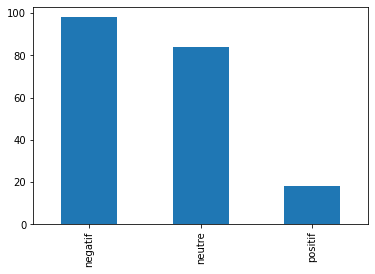

In [39]:
echantillon["sentiment"] = echantillon["sentiment_all"].apply(lambda x : x[0]["label"])
echantillon["sentiment"].value_counts().plot(kind="bar")

Quels sont les tweets "positifs" ?

In [40]:
echantillon[echantillon["sentiment"] == "positif"]["texte"]

date
2020-03-17 10:45:44+00:00    Personne n’est à l’abri. Il n’y a pas d’autres...
2020-03-13 10:23:44+00:00    Et pour préparez votre visite de l'expo  #Expo...
2020-03-14 22:20:50+00:00    @bah_moise Je t'assure toi tu n'auras jamais c...
2020-03-17 18:00:10+00:00    C'est sur il y aura un avant et un après #covi...
2020-03-16 11:12:06+00:00    Suite aux décisions gouvernementales pour limi...
2020-03-15 08:21:21+00:00    Pour rappel ! Notre matériel medical de protec...
2020-03-16 14:13:37+00:00    «L&amp;#39;Italie a besoin d&amp;#39;aide» pou...
2020-03-14 23:09:33+00:00    La Chine 🇨🇳 célèbre sa victoire face au #coron...
2020-03-17 20:37:53+00:00    Allô Bazaiba !\nIci on travaille 👌 https://t.c...
2020-03-16 08:42:33+00:00    Le Fonds de dotation Interconstruction était s...
2020-03-17 10:13:49+00:00    Ceux qui se connaissent un peu en écologie, on...
2020-03-14 16:33:39+00:00    Si l’Inter peut montrer la voie à tous les clu...
2020-03-13 01:45:11+00:00    Oubliez le #corona

### 3.3 Orientation des différents comptes

Avec un traitement sur l'ensemble du corpus, il est possible de calculer un score de négativité/neutralité/positivité par compte afin d'identifier les comptes les plus extrêmes. Pour réduire le temps de calcul on se concentre sur les comptes les plus actifs.

1. On ne garde que les comptes qui ont plus de 5 tweets dans notre base de données
2. On calcule le sentiment pour chaque compte
3. On calcule la proportion de chaque sentiment.

In [41]:
# Calculer le nombre de tweets par compte
nb_tweets_par_user = corpus_total_fr.groupby("user_screename")["id"].count()

# nombre de tweets concernés
nb_tweets_par_user[nb_tweets_par_user > 5].sum()

27440

In [42]:
# filtre des comptes à garder
filtre = corpus_total_fr["user_screename"].isin(nb_tweets_par_user[nb_tweets_par_user > 5].index)

# sélection des tweets concernés
tweets_plus_de_5 = corpus_total_fr[filtre]

# application du modèle
tweets_plus_de_5["sentiment_all"] = tweets_plus_de_5["texte"].apply(modele2)

# ne garder que le label
tweets_plus_de_5["sentiment"] = tweets_plus_de_5["sentiment_all"].apply(lambda x : x[0]["label"])

/tmp/ipykernel_32041/1608999569.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_plus_de_5["sentiment_all"] = tweets_plus_de_5["texte"].apply(modele2)
/tmp/ipykernel_32041/1608999569.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_plus_de_5["sentiment"] = tweets_plus_de_5["sentiment_all"].apply(lambda x : x[0]["label"])


Maintenant, il reste à calculer une proportion par compte. Le plus simple est de définir une fonction que l'on va appliquer sur un tableau de tweets (celui du compte) en spécifiant la modalité que l'on souhaite garder de la distribution.

In [43]:
def prop(tab, mod):
    """
    Renvoyer la proportion d'une modalité entre 0 et 1
    
    Parameters
    ----------
    tab : pandas.Series
        Liste de tweets groupés par utilisateur
        
    mod : string
        Modalité
        
    Returns
    -------
    prop_mod : float
        Proportion de la modalité dans la liste de tweets
    """
    # calcul de la distribution
    distribution = tab.value_counts(normalize=True)
    
    if mod in distribution.index:
        return distribution.loc[mod]
    
    # cas où la modalité est absente
    return 0

On applique cette fonction sur l'ensemble de notre corpus.

In [44]:
# Grouper par compte, prendre la colonne des sentiments et appliquer la fonction
negativite_comptes = tweets_plus_de_5.groupby("user_screename")["sentiment"].apply(lambda x : prop(x, "negatif"))

# Afficher les comptes les plus négatifs
negativite_comptes.sort_values(ascending=False).head()

user_screename
FouzaiHamdi        1.0
_DataStrategies    1.0
Vivrevieille       1.0
reneguenon666      1.0
FrederickPonsot    1.0
Name: sentiment, dtype: float64

On peut donc explorer les comptes négatifs, comme `bonuscr`

In [45]:
list(corpus_total_fr[corpus_total_fr["user_screename"] == "bonuscr"]["texte"])

['#Pelloux il va encore bosser à la hosto? Pour l instant il se ballade entre réunion avec Hidalgo pour dire qu il ne faut pas décaler les élections , entre plateaux TV et autres plateaux radio https://t.co/OctTXN847D',
 '@LeaSalame @franceinter vous ne Suivez pas les infos? N appelez pas le 15 et ca plus d 1 mois que le dispositif existe .. ca vous aurait échappé ? https://t.co/Z6mPiDlWBn',
 'La sauterie de Hidalgo avec Lula? Sans compter les photos de métro , les pots avec ses potes dans des cafés des quartiers popu. Toussa toussa . https://t.co/3BlTApNJAx',
 '@MatthieuGariel C est effrayant ! Au bureau on m appelle l ayatollah du coronavirus . Hypocondriaque de surcroît ..  a vue de nez 20 % respectent les gestes barrières.',
 'En Italie strictement confinés les italiens se retrouvent sur les balcons pour chanter l hymne  nationale ns a de gros beaufs violents qui se posent là en vecteur de virus. Bref leur vraie nature .. et pour ts ceux qui les trouvaient si sympathiques allez vou

In [46]:
Tweet("1238777176016801794")

Une analyse similaire peut être menée en regroupant cette fois par hashtags pour identifier leur dimension plus ou moins négative.

## 4. Analyse de réseaux

Les données de Twitter s'inscrivent naturellement dans une perspective relationnelle : réseau social, les comptes se suivent les uns les autres, les utilisateurs retweetent des tweets. Ainsi, plusieurs dimensions relationnelles peuvent être analysées : les interactions elles-mêmes, notamment par le fait de retweeter ; les liens structurels, notamment le fait de suivre/d'être suivi par un compte ; mais aussi des aspects plus analytiques comme le fait de partager certains hashtags ou certains liens. 

Dans notre cas, nous ne travaillons pas sur le corpus des retweets (ce serait un autre travail), mais sur le corpus des tweets originaux. Nous allons donc nous intéresser à trois dimensions :

- l'évolution des groupes de hashtags (#) dans le temps, en construisant le réseau journalisé de la proximité entre les hashtags
- la proximité entre les comptes qui partagent un même contenu (des liens similaires)
- la proximité des comptes qui se mentionnent les uns les autres (@)

Dans les deux cas, la stratégie va être la même :

1. Construire le réseau souhaité avec la bibliothèque `networkx`;
2. Explorer ou visualiser tout ou une partie du réseau (des outils comme **Gephi** <https://gephi.org/> sont adaptés pour cela, la visualisation exploratoire directement dans le notebook n'étant pas la plus facile)
3. Construire les métriques et indicateurs utiles pour répondre à la question et synthétiser les résultats.

Nous allons nous concentrer sur un jour en particulier, ce qui permet d'ouvrir la réflexion sur la comparaison entre différents jours.

In [47]:
per_day = corpus_total_fr.resample("d")
corpus_fr_12032020 = list(per_day)[1][1]

### 4.1 Groupes de mots clés


La première étape est de construire un réseau

In [48]:
from itertools import combinations
import networkx as nx

# création d'un réseau vide
reseau = nx.Graph()

# boucle sur chaque tweet qui a des entités
for i, ligne in corpus_fr_12032020.iterrows():
    
    # détecter les hashtags
    hashtags = extraire_hashtags(ligne["texte"])
    
    # pour chaque entitée
    for element in hashtags:
        # si le hashtags n'est pas présent
        if not element in reseau.nodes:
            reseau.add_node(element, label=element, poids=1)
        else:
            reseau.nodes[element]["poids"] += 1
            
    # pour chaque paire d'entités
    for i, j in combinations(hashtags, 2): 
        
        # Si le lien n'existe pas, le créer, sinon incrémenter
        if not reseau.has_edge(i, j):
            reseau.add_edge(i, j, poids=1)
        else:
            reseau[i][j]["poids"] += 1

On peut maintenant regarder le réseau produit

In [49]:
len(reseau.nodes),len(reseau.edges)

(4099, 15454)

On peut calculer différentes statistiques sur ce réseau. La première est de s'intéresser aux nœuds les plus centraux non pas seulement en termes de fréquence dans les tweets, mais en termes de degrés. Le second est de regarder les tweets les plus centraux en termes de position dans le graphe, notamment avec des indicateurs de *betweenness*.

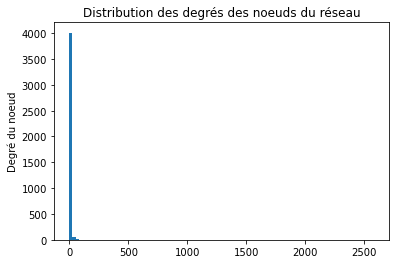

In [50]:
degres = dict(reseau.degree)

plt.hist(degres.values(),bins=100)
plt.title("Distribution des degrés des noeuds du réseau")
plt.ylabel("Degré du noeud")
plt.show()

Il y a peu de nœuds centraux

In [51]:
noeux_centraux = [i for i in degres if degres[i] > 50]
noeux_centraux

['coronavirus',
 'covid19',
 'covid_19',
 'confinement',
 'municipales2020',
 'coronavirusfr',
 'covid19france',
 'kebetu',
 'covid',
 'santé',
 'virus',
 'trump',
 'covid19fr',
 'covidー19',
 'coronavirusfrance',
 'coronapocalypse',
 'pandemie',
 'france',
 'coronaoutbreak',
 'italie',
 'pandémie',
 'macron',
 'afrique',
 'paris',
 'corona',
 'bfmtv',
 'municipales',
 'covid_19fr',
 'usa',
 'sante',
 'lrem',
 'acte70',
 'giletsjaunes',
 'coronavirusupdates',
 'gouvernement',
 'lci',
 'edouardphilippe',
 'restezchezvous',
 'restecheztoi',
 'municipale2020']

Concentrons-nous sur les hashtags qui sont utilisés, donc qui apparaissent au moins 2 fois.

In [52]:
noeuds_conserves = [n for n, v in reseau.nodes(data=True) if v['poids'] >= 2]  
reseau_filtre = reseau.subgraph(noeuds_conserves)

Nombre de composantes séparées (non connectées entre elles)

In [53]:
nx.number_connected_components(reseau_filtre)

43

Nombre d'éléments dans les composantes : on peut se débarasser des composantes unitaires

In [54]:
composantes = [i for i in nx.connected_components(reseau_filtre)]
pd.Series([len(i) for i in composantes]).value_counts()

1      36
2       5
999     1
6       1
dtype: int64

Regardons le contenu des petites composantes

In [55]:
[i for i in composantes if len(i) < 10]

[{'googlealerts'},
 {'imposture'},
 {'rtssport'},
 {'ffvoilefédérationfrançaisedevoile', 'solomaîtrecoq'},
 {'buonnatale', 'christmas', 'joyeuxnoel', 'merrychristmas', 'natale', 'noel'},
 {'cflinfosall'},
 {'thd'},
 {'cymes'},
 {'maineetloire'},
 {'rambouillet'},
 {'8217'},
 {'directlnc', 'lncmonde'},
 {'alertswiss'},
 {'rotary'},
 {'medias24'},
 {'hitech'},
 {'t9n', 'xl8'},
 {'démasquonsmacron'},
 {'liguemagnus'},
 {'lfrii', 'lfriimedia'},
 {'mustread'},
 {'lexisactu'},
 {'arcgisstorymaps', 'storymap'},
 {'bkd'},
 {'urgence'},
 {'digitalweekend'},
 {'auxerre'},
 {'goal'},
 {'coronavirus_en_algerie'},
 {'end'},
 {'lavezvouslesmains'},
 {'vr'},
 {'darwinawards'},
 {'brexit'},
 {'jdm'},
 {'1040be'},
 {'smackdownab'},
 {'pl'},
 {'cdiscountsauvemonvendredi13'},
 {'blackstar'},
 {'ciel'},
 {'revuedepresse'}]

On peut donc se concentrer sur la composante principale, en reprenant un sous graphe

In [56]:
reseau_filtre = reseau.subgraph([i for i in composantes if len(i) > 10][0])
len(reseau_filtre)

999

Une première stratégie d'exploration du réseau est d'utiliser un logiciel dédié et parfaitement adapté : Gephi. Pour cela, la méthode la plus adaptée est d'exporter le réseau souhaité sous un format facilement lisible, comme le *GraphML*, et d'utiliser le logiciel pour identifier les traitements. Gephi permet de faire une partie de l'analyse ; une autre peut ensuite être réalisée avec Python, potentiellement en rechargeant le réseau modifié.

Génération d'un fichier qui peut être lu par Gephi :

In [57]:
nx.write_graphml(reseau_filtre, "reseau_filtre.graphml")

Il ne reste plus qu'à l'ouvrir avec Gephi. 

Il est cependant aussi possible de produire des visualisations directement en Python. Une visualisation de réseau est un équilibre compliqué entre la complexité du réseau et son intelligibilité.

Une grande partie de la lisibilité d'un réseau dépend
1. de la stratégie de spatialisation utilisée,
2. des modifications sur le réseau (filtrer, regrouper, enlever des éléments centraux),
3. du choix de couleurs fait.

La bibliothèque `networkx` permet de faire des visualisations même si elle peut rencontrer certaines limites avec de très grands réseaux. La stratégie est alors toujours la même : générer une spatialisation (une coordonnée pour chaque nœud), puis dessiner le réseau (nœuds, liens, labels, en spécifiant les couleurs).

Pour les grands réseaux, la spatialisation "Force Atlas 2" implémentée sous Gephi est souvent utilisée. Il existe une implémentation sous networkx, à installer. De nombreux paramètres peuvent être choisis pour modifier le rendu final.

In [58]:
from fa2 import ForceAtlas2
forceatlas2 = ForceAtlas2(
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        edgeWeightInfluence=0.1,
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        scalingRatio=10,
                        strongGravityMode=False,
                        gravity=0.0001,
                        verbose=True)

# calcul des positions
positions = forceatlas2.forceatlas2_networkx_layout(reseau_filtre, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:22<00:00, 87.15it/s] 

BarnesHut Approximation  took  4.75  seconds
Repulsion forces  took  16.36  seconds
Gravitational forces  took  0.09  seconds
Attraction forces  took  0.69  seconds
AdjustSpeedAndApplyForces step  took  0.52  seconds


Une fois la position calculée, il est facile ensuite de produire la visualisation

/opt/conda/envs/DeepLearning/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/envs/DeepLearning/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/envs/DeepLearning/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/envs/DeepLearning/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


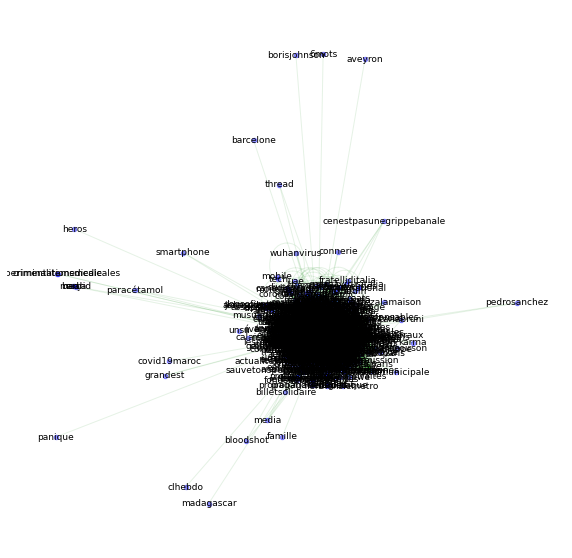

In [59]:
fig,ax = plt.subplots(figsize=(10,10))
nx.draw_networkx_nodes(reseau_filtre, positions, node_size=20, node_color="blue", alpha=0.4, ax=ax)
nx.draw_networkx_edges(reseau_filtre, positions, edge_color="green", alpha=0.1, ax=ax)
nx.draw_networkx_labels(reseau_filtre, pos=positions, ax=ax, font_size=9)
plt.axis('off')
plt.show()

Le réseau est très compact. Il est possible de l'explorer en regardant différentes configurations de paramètres, ou d'essayer de repérer les sous-communautés avec un algorithme de clusterisation.

In [60]:
import networkx as nx
import networkx.algorithms.community as nx_comm

In [61]:
# Identification des clusters
seuil = 1  # Définition d'un seuil (qui détermine le nombre de clusters)
clusters = nx_comm.louvain_communities(reseau_filtre, seed=123, weight="poids", threshold=seuil)

print(f"Il y a {len(clusters)} clusters")

Il y a 106 clusters


In [62]:
clusters[0:5]

[{'amazon'},
 {'caf', 'cameroun', 'chan2020'},
 {'aidonsnosmolosses',
  'animaux',
  'associationanm',
  'chat',
  'chien',
  'dog',
  'doglife',
  'doglovers',
  'dogsofinstagram',
  'jenesuispasunvirus',
  'lapsychose'},
 {'distancesociale', 'pedagogie', 'socialdistancing'},
 {'actualités',
  'adha',
  'africa',
  'afrique',
  'alaune',
  'buzz',
  'cov19sn',
  'covid19gn',
  'covid19sn',
  'dakar',
  'fagarungirmuccu',
  'india',
  'information',
  'islam',
  'kebetu',
  'milclicks',
  'nouvellephotodeprofil',
  'senegal',
  'sénégal',
  'team221',
  'tl221'}]

On peut alors les représenter sur le réseau, en générant une couleur aléatoire par groupe. Dans les faits, on garde la même distribution qu'initialement, et on trace chaque cluster indépendamment avec une couleur différente.

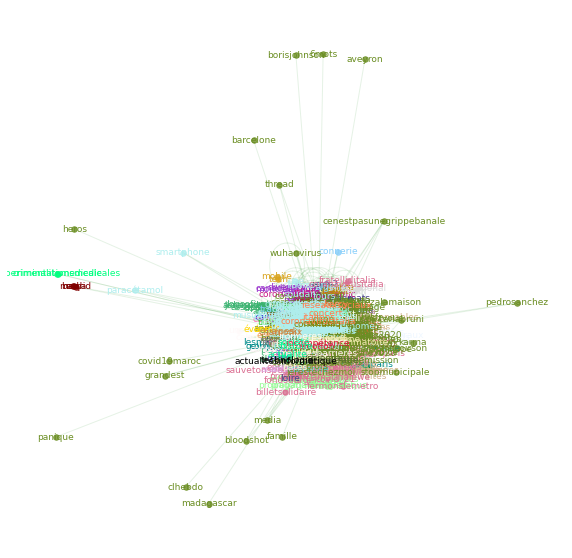

In [63]:
import matplotlib.colors as mcolors
import random
random.choice(list(mcolors.CSS4_COLORS))

fig,ax = plt.subplots(figsize=(10,10))

# Tracer à part chaque cluster
for c in clusters:
    color = random.choice(list(mcolors.CSS4_COLORS))
    nx.draw_networkx_nodes(reseau_filtre, positions, nodelist=c, node_size=30,  node_color=color, alpha=0.8,ax=ax)
    nx.draw_networkx_labels(reseau_filtre, labels={i: i for i in c}, pos=positions, ax=ax, font_size=9, font_color=color)

# Tracer les liens
nx.draw_networkx_edges(reseau_filtre, positions, edge_color="green", alpha=0.1,ax=ax)

plt.axis('off')
plt.show()

Une fois analysé sur un jour, il est possible d'envisager de construire le réseau sur différents jours, de comparer la forme du réseau, l'évolution de la centralité des mots-clés, etc. Nous vous laissons ça en exercice :).

### 4.2 Réseau du partage de lien

Les liens sont des marqueurs de l'intérêt mais aussi de l'orientation politique des individus. En regardant qui partage quel lien, il est possible d'identifier des proximités de positionnement des individus.

De manière similaire au cas précédent, nous allons construire le réseau des liens, cette fois-ci sur l'ensemble des données. Deux comptes d'utilisateurs sont connectés s'ils partagent un lien.

1. On construit un dictionnaire compte/lien ;
2. Pour chaque connection, on augmente du nombre de liens ;
3. On peut normaliser le poids des liens en fonction du nombre total de liens partagé par chaque compte.

In [64]:
# uniquement les urls en fixe
corpus_total_fr["urls_expanded"] = corpus_total_fr["urls"].apply(lambda x : [i["expanded_url"] for i in x])

# pour chaque utilisateur, la liste des liens
tableau_user_liens = corpus_total_fr.groupby("user_screename")["urls_expanded"].sum()

# garder uniquement les utilisateurs ayant partagé au moins trois liens
tableau_user_liens = tableau_user_liens[tableau_user_liens.apply(len) > 2].apply(set)

# dictionnaire utilisateur/lie
tableau_user_liens = dict(tableau_user_liens)

Il reste à construire le réseau

In [65]:
# liste des utilisateurs
users = list(tableau_user_liens.keys())

# nouveau réseau
reseau = nx.Graph()

# pour chaque paire d'utilisateurs
for i in range(0, len(users)):
    for j in range(i+1, len(users)):
        
        # l'intersection entre les deux ensembles de liens échangés
        n = len(tableau_user_liens[users[i]].intersection(tableau_user_liens[users[j]]))
        
        # s'il y a un lien, ajouter les noeuds si besoin et le lien
        if n > 0:        
            if not users[i] in reseau.nodes:
                reseau.add_node(users[i],label=users[i],poids=len(tableau_user_liens[users[i]]))
            if not users[j] in reseau.nodes:
                reseau.add_node(users[j],label=users[j],poids=len(tableau_user_liens[users[j]]))
                
            reseau.add_edge(users[i],users[j],poids=n)

Une fois le réseau construit, il est possible de visualiser. On reste sur une visualisation Force Atlas 2 : 

100%|██████████| 2000/2000 [03:22<00:00,  9.87it/s]


BarnesHut Approximation  took  61.90  seconds
Repulsion forces  took  129.56  seconds
Gravitational forces  took  0.39  seconds
Attraction forces  took  6.10  seconds
AdjustSpeedAndApplyForces step  took  2.13  seconds


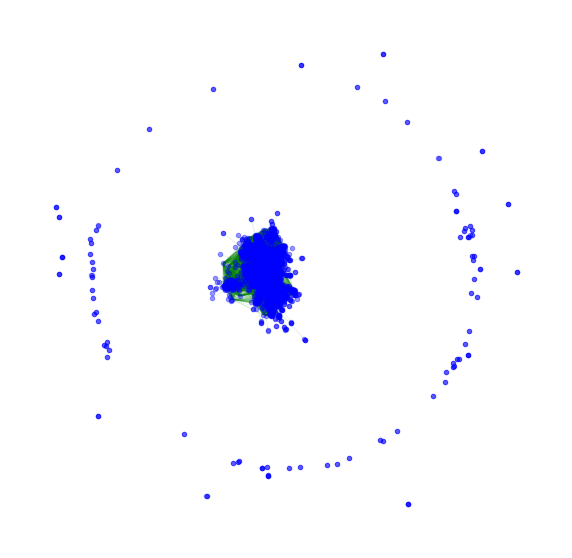

In [66]:
from fa2 import ForceAtlas2
forceatlas2 = ForceAtlas2(
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        edgeWeightInfluence=0.01,
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        scalingRatio=1,
                        strongGravityMode=False,
                        gravity=0.1,
                        verbose=True)

# calcul des positions
positions = forceatlas2.forceatlas2_networkx_layout(reseau, pos=None, iterations=2000)

fig,ax = plt.subplots(figsize=(10,10))
nx.draw_networkx_nodes(reseau, positions, node_size=20,  node_color="blue", alpha=0.4,ax=ax)
nx.draw_networkx_edges(reseau, positions, edge_color="green", alpha=0.1,ax=ax)
#nx.draw_networkx_labels(reseau, pos=positions,ax=ax, font_size=9)
plt.axis('off')
plt.show()

L'étape d'après est d'identifier les regroupements, et de comprendre les proximités en regardant les liens partagés.

### 4.3 Discussions entre les utilisateurs

La logique reste la même. La seule différence est que cette fois nous cherchons les mentions d'autres utilisateurs, le réseau est alors plus simple à construire.

La première étape est d'identifier les utilisateurs dans chaque tweet : 

In [67]:
def extraire_users(texte):
    """
    Extraire les utilisateurs mentionnés d'un texte
    
    Parameters
    ----------
    texte : string
        Texte
    
    Returns
    -------
    liste : list
        Liste de noms d'utilisateurs
    """
    expression = "@(\w+)"
    liste = re.findall(expression, texte.lower())
    return liste

corpus_total_fr["mention_users"] = corpus_total_fr["texte"].apply(extraire_users)
compteur = Counter()
for l in list(corpus_total_fr["mention_users"]):
    compteur.update(l)
compteur.most_common(10)

[('emmanuelmacron', 1276),
 ('franceinfo', 936),
 ('lemondefr', 765),
 ('youtube', 645),
 ('bfmtv', 536),
 ('ephilippepm', 525),
 ('20minutes', 409),
 ('olivierveran', 407),
 ('le_parisien', 400),
 ('gouvernementfr', 359)]

In [68]:
# nouveau réseau
reseau = nx.Graph()

# pour chaque ligne
for i, ligne in corpus_total_fr.iterrows():

    # S'il y a une mention d'utilisateur
    if len(ligne["mention_users"]) > 0:
        
        # Ajouter ou augmenter l'utilisateur
        user = ligne["user_screename"]
        if not user in reseau.nodes:
            reseau.add_node(user, label=user, poids=1)
        else:
            reseau.nodes[user]["poids"] += 1
            
        # Pour chaque référence, faire de même et ajouter un lien
        for ref in ligne["mention_users"]:      

            if not ref in reseau.nodes:
                reseau.add_node(ref, label=ref, poids=1)
            else:
                reseau.nodes[ref]["poids"] += 1
            if not reseau.has_edge(user, ref):
                reseau.add_edge(user, ref, poids=1)
            else:
                reseau[user][ref]["poids"]+=1
                
print("Nombre de noeuds:", len(reseau.nodes))
print("Nombre de liens:", len(reseau.edges))
print("Nombre de composantes:", nx.number_connected_components(reseau))

Nombre de noeuds: 44159
Nombre de liens: 48101
Nombre de composantes: 6567


C'est un réseau très épars ! Plutôt que de regarder tout le réseau, on veut observer le périmètre d'un nœud particulier.

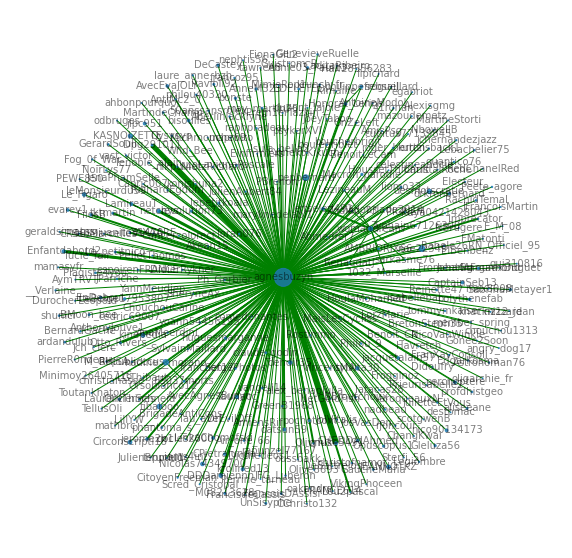

In [69]:
# Définir l'utilisateur
utilisateur = 'agnesbuzyn'

# Sous-réseau
sous_reseau = nx.ego_graph(reseau,utilisateur,1)

# Afficher
fig,ax = plt.subplots(figsize=(10,10))
position = nx.spring_layout(sous_reseau)
poids_liens = [sous_reseau[u][v]['poids'] for u,v in sous_reseau.edges()]
poids_noeuds = [i[1] for i in sous_reseau.nodes(data="poids")]
nx.draw_networkx_nodes(sous_reseau, position, node_size=poids_noeuds, alpha=0.8,ax=ax)
nx.draw_networkx_labels(sous_reseau, pos=position,ax=ax,font_size=10,alpha=0.5)
nx.draw_networkx_edges(sous_reseau, pos=position, width=poids_liens,ax=ax,edge_color="green", alpha=1)
plt.axis('off')
plt.show()

Cela permet d'explorer non seulement les comptes qui interpellent fréquemment un compte, mais aussi en regardant le périmètre d'ordre 2 les autres mentions associées.

## Conclusion

Ce notebook présente l'ensemble de la démarche de collecte, de mise en forme et d'analyse de données issues de Twitter. Il s'est concentré sur la présentation des différentes étapes et un bouquet de stratégies d'analyse. Les données des tweets peuvent être analysées suivant de nombreuses dimensions, selon la problématique :
* à l'échelle des comptes, il est possible de s'intéresser à leur description et au contenu produit sur une période ;
* à l'échelle des tweets, il est possible de regarder le contenu soit sous la forme des hashtags, des liens mais aussi des informations véhiculées par le texte ;
* ces tweets peuvent être agrégés pour suivre les évolutions temporelles ;
* enfin, à l'échelle plus structurelle, de nombreuses dimensions relationnelles permettent de construire des analyses sur la position d'un utilisateur/tweets dans la dynamique plus générale.

Chaque stratégie mobilise une palette d'outils spécifique :
* pour l'analyse de réseaux, les métriques et algorithmes de clusterisation permettent de renseigner la structure du réseau ;
* pour le contenu des tweets, les outils de traitement automatique de la langue permettent de classifier différentes dimensions de la proximité de textes au sentiment.

Ces stratégies évoluent rapidement avec l'introduction de nouvelles méthodes et procédures, les plus récentes croisent d'ailleurs les informations structurelles du réseau (*network embedding*) avec le contenu du texte (*text embedding*) pour caractériser les individus et leurs évolutions dans le temps. 

Ces données sont largement utilisées par les sciences sociales car contrairement à d'autres plateformes, les conditions d'utilisations sont plus souples. Néanmoins, certaines contraintes doivent être respectées : les conditions d'utilisation de Twitter, la création d'un identifiant pour hydrater les tweets, et des conditions sur la diffusion des résultats. 